<a href="https://colab.research.google.com/github/RithwikMohan/ML_Lab/blob/main/ML_ASSIGNMENT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spectral clustering**
Spectral clustering is a graph-based clustering algorithm that groups data points based on the spectrum (eigenvalues) of a similarity matrix of the data.

Unlike k-means or DBSCAN, which work in the original feature space, spectral clustering works in a transformed space where clusters are easier to separate.

numpy, pandas: for calculations and saving results

sklearn datasets, preprocessing, clustering, metrics

PCA, t-SNE, UMAP : dimension reduction techniques

matplotlib : plotting clusters

warnings : suppress warnings for cleaner output





In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

We use the Breast Cancer Wisconsin dataset : a real-world medical dataset with features extracted from cancer cell images.

In [21]:
# 1. Load dataset
data = load_breast_cancer()
X = data.data
y_true = data.target
feature_names = data.feature_names
print("Dataset loaded. Shape:", X.shape)

Dataset loaded. Shape: (569, 30)


We standardize the dataset so all features have the same scale. This is important for clustering algorithms.

In [23]:
# 2. Preprocess data: Scaling
X_scaled = StandardScaler().fit_transform(X)


We run Spectral Clustering with default parameters to get a baseline performance.


*  Silhouette Score : how well-separated clusters are (1 is best).

*  Adjusted Rand Index (ARI) : how well clusters match ground truth labels.



In [24]:
# 3. Baseline Spectral Clustering
baseline = {}
sc = SpectralClustering(n_clusters=2, affinity='rbf', random_state=42)
labels_baseline = sc.fit_predict(X_scaled)
baseline['Silhouette'] = silhouette_score(X_scaled, labels_baseline)
baseline['ARI'] = adjusted_rand_score(y_true, labels_baseline)
print("Baseline Results:", baseline)

Baseline Results: {'Silhouette': np.float64(0.6606668813897673), 'ARI': 0.0048283446965917305}


# **Preprocessing Methods**

We try several dimension reduction techniques:

PCA_2 : PCA reducing to 2 dimensions

PCA_5 : PCA reducing to 5 dimensions

UMAP_2, UMAP_5 : Uniform Manifold Approximation and Projection

TSNE_2 : t-SNE reducing to 2 dimensions

These reduce complexity and help clustering.

In [25]:
# 4. Preprocessing methods
reducers = {
    'PCA_2': PCA(n_components=2),
    'PCA_5': PCA(n_components=5),
    'UMAP_2': umap.UMAP(n_components=2, random_state=42),
    'UMAP_5': umap.UMAP(n_components=5, random_state=42),
    'TSNE_2': TSNE(n_components=2, random_state=42),
}


# **Hyperparameter Tuning**

Hyperparameter tuning is the process of finding the best settings for the parameters of a machine learning algorithm that are set before training (hyperparameters), in order to maximize the model’s performance.

Unlike normal parameters (like weights in neural networks), hyperparameters are not learned automatically during training — we must define them before running the model.



We systematically vary:

Affinity → rbf (default) or nearest_neighbors

Number of neighbors : [5, 10, 15] (for nearest_neighbors affinity)

Number of clusters : [2, 3, 4, 5]

For each combination:

We run Spectral Clustering.

Calculate Silhouette Score and ARI.

Store results.

In [27]:
# 5. Hyperparameter tuning
tuned_results = {}

for red_name, reducer in reducers.items():
    print(f"Preprocessing: {red_name}")
    X_red = reducer.fit_transform(X_scaled)

    for affinity in ['rbf', 'nearest_neighbors']:
        for n_neighbors in [5, 10, 15] if affinity=='nearest_neighbors' else [None]:
            for n_clusters in [2, 3, 4, 5]:
                try:
                    sc = SpectralClustering(
                        n_clusters=n_clusters,
                        affinity=affinity,
                        n_neighbors=n_neighbors,
                        assign_labels='kmeans',
                        random_state=42
                    )
                    labels = sc.fit_predict(X_red)
                    if len(set(labels)) <= 1:
                        continue

                    sil = silhouette_score(X_red, labels)
                    ari = adjusted_rand_score(y_true, labels)

                    tuned_results[f"{red_name}_aff={affinity}_nn={n_neighbors}_k={n_clusters}"] = {
                        "Silhouette": sil,
                        "ARI": ari,
                        "red_name": red_name,
                        "affinity": affinity,
                        "n_neighbors": n_neighbors,
                        "n_clusters": n_clusters
                    }
                except Exception as e:
                    continue

Preprocessing: PCA_2
Preprocessing: PCA_5
Preprocessing: UMAP_2


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Preprocessing: UMAP_5


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Preprocessing: TSNE_2


# **Find Best Parameters**

We pick the combination with the highest Silhouette Score as the best configuration.

In [28]:
best = max(tuned_results.items(), key=lambda kv: kv[1]["Silhouette"])
print("\nBest Tuned Config:", best[0], best[1])


Best Tuned Config: UMAP_5_aff=nearest_neighbors_nn=5_k=2 {'Silhouette': np.float32(0.60200393), 'ARI': 0.7730279453443412, 'red_name': 'UMAP_5', 'affinity': 'nearest_neighbors', 'n_neighbors': 5, 'n_clusters': 2}


# **Visualization**

We compare baseline clusters vs best tuned clusters:

Using PCA reduced data to 2D.

Plot them side-by-side for visual comparison.

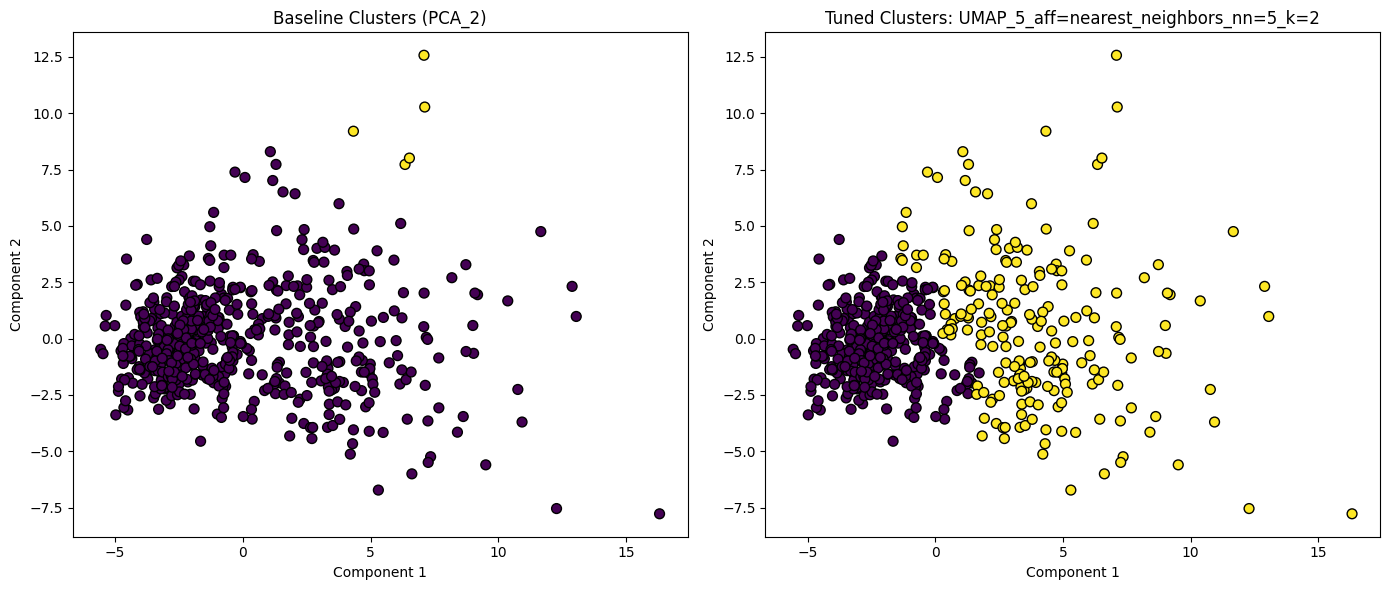

In [29]:
# 7. Visualization: Baseline vs Best Tuned Clusters
if 'PCA_2' in reducers:
    X_p2 = reducers['PCA_2'].fit_transform(X_scaled)

    # Baseline
    scb = SpectralClustering(n_clusters=2, affinity='rbf', random_state=42)
    labels_base_red = scb.fit_predict(X_p2)

    # Best Tuned
    bc = best[1]
    sc_best = SpectralClustering(
        n_clusters=bc['n_clusters'],
        affinity=bc['affinity'],
        n_neighbors=bc['n_neighbors'],
        assign_labels='kmeans',
        random_state=42
    )
    labels_best_red = sc_best.fit_predict(X_p2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].scatter(X_p2[:, 0], X_p2[:, 1], c=labels_base_red, cmap='viridis', edgecolor='k', s=50)
    axes[0].set_title("Baseline Clusters (PCA_2)")
    axes[0].set_xlabel("Component 1")
    axes[0].set_ylabel("Component 2")

    axes[1].scatter(X_p2[:, 0], X_p2[:, 1], c=labels_best_red, cmap='viridis', edgecolor='k', s=50)
    axes[1].set_title(f"Tuned Clusters: {best[0]}")
    axes[1].set_xlabel("Component 1")
    axes[1].set_ylabel("Component 2")

    plt.tight_layout()
    plt.show()



# **Baseline Clusters (PCA_2)**

This shows the clustering result when default hyperparameters were used for Spectral Clustering without tuning.

The preprocessing here used PCA reducing the dataset to 2 dimensions (PCA_2).

Each point is a data sample, and colors represent different clusters detected by the algorithm.

Since no tuning was applied, clustering quality is lower — clusters are not very distinct, and some points might be incorrectly grouped or noise points might be present.

# **Tuned Clusters: UMAP_5_aff=nearest_neighbors_nn=5_k=2**

This shows the clustering result after hyperparameter tuning:

Preprocessing: UMAP reducing to 5 dimensions (UMAP_5)

Affinity: nearest neighbors

n_neighbors: 5

n_clusters (k): 2

These tuned parameters were chosen because they maximized the Silhouette Score in your experiment.

The clusters here are more distinct and better separated compared to the baseline.

This graph demonstrates how tuning preprocessing and clustering parameters can improve the clustering outcome.

# **Key takeaway from these graphs**

The comparison visually proves hyperparameter tuning improves clustering quality:

Baseline clustering has more overlap and noise.

Tuned clustering shows clearer cluster separation and better structure.